<a href="https://colab.research.google.com/github/liuyyn/attention-is-all-you-need/blob/main/AttentionIsAllYouNeed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets

## Steps
1. Attention Mechanism
2. Transformer Block
3. Encoder
4. Decoder Block
5. Decoder
5. Transformer

In [ ]:
import torch
import torch.nn as nn

## 1 - Self Attention Mechanism

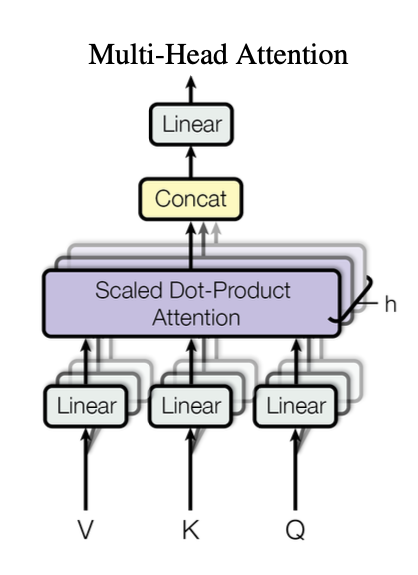

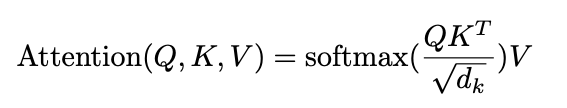

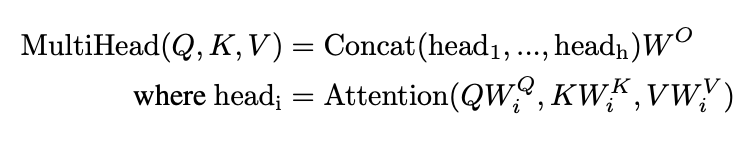

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, embed_size, heads):
    super(SelfAttention, self).__init__()
    self.embed_size = embed_size # d_model
    self.heads = heads # h
    self.head_dim = embed_size // heads # dk = dv = d_model / h

    assert (self.embed_size % self.heads == 0) # embedding size d_model needs to be a factor of # heads i.e. head_dim*heads=embed_size

    # initialize values, keys, queries
    # V = V * W_v
    # K = K * W_k
    # Q = Q * W_q
    # MultiHead(Q, K, V) = Concat(head_1, ..., head_h)*W_o where head_i = Attention(Q*W_q, K*W_k, V*W_v)
    self.values = nn.Linear(self.head_dim, self.head_dim, bias=False) # input size, output size
    self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False) # input size, output size
    self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False) # input size, output size

    self.fc_out = nn.Linear(self.embed_size, self.embed_size) # fully connected - last linear layer after the concat

  def forward(self, values, keys, queries, mask):
    # shape: batch, sentence_length, embedding_dim
    N = queries.shape[0]
    value_len, key_len, query_len = values.shape[1], keys.shape[1], queries.shape[1]

    # Split embeddings into self.head pieces
    # values: N x value_len
    # keys: N x key_len
    # queries: N x query_len
    # after reshape values: N x val_len x h x d_v
    values = values.reshape(N, value_len, self.heads, self.head_dim)
    keys = keys.reshape(N, key_len, self.heads, self.head_dim)
    queries = queries.reshape(N, query_len, self.heads, self.head_dim)

    # send through linear layer
    values = self.values(values)
    keys = self.keys(keys)
    queries = self.queries(queries)

    # Scaled dot product attention
    # for batch matrix multiplication, notation is "bij,bjk->bik"
    queries_dot_keys = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
    # queries shape: (N, query_len, heads, head_dim)
    # keys shape: (N, key_len, heads, head_dim)
    # queries_dot_keys shape: (N, heads, query_len, key_len)

    # apply mask if there is one
    if mask is not None:
      queries_dot_keys = queries_dot_keys.masked_fill_(mask == False, float("-inf"))


    # divide by dk = dmodel/h i.e. dimension of keys and apply softmax on result
    attention = torch.softmax(queries_dot_keys / (self.head_dim ** (1/2)), dim=3)

    out = torch.einsum("nhql,nlhd->nqhd", [attention, values])
    # attention shape: (N, heads, query_len, key_len)
    # values shape: (N, value_len, heads, head_dim)
    # out shape: (N, query_len, heads, head_dim)
    # the shape for K and V will always be the same - queries shape differ in second attention layer of decoder

    # concat the heads i.e. flatten last 2 dimensions of out
    multihead_attention = out.reshape(N, query_len, self.heads*self.head_dim) # self.embed_size = self.heads*seld.head_dim

    # last linear layer
    multihead_attention = self.fc_out(multihead_attention)


    return multihead_attention

## 2 - Transformer Block

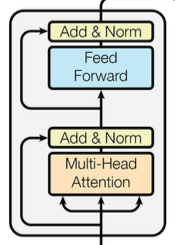

### Residual Dropout
We apply dropout [33] to the output of each sub-layer, before it is added to the sub-layer input and normalized. In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks. For the base model, we use a rate of Pdrop = 0.1.

### Position-wise Feed-Forward Networks
In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

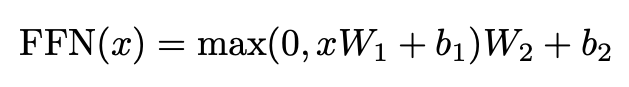

While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1. The dimensionality of input and output is dmodel = 512, and the inner-layer has dimensionality dff =2048.

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, embed_size, heads, dropout=0.1, forward_expansion=4):
    super(TransformerBlock, self).__init__()

    self.attention = SelfAttention(embed_size=embed_size, heads=heads)
    self.norm1 = nn.LayerNorm(embed_size) # takes the average for each example and normalizes the tensor

    self.feed_forward = nn.Sequential(
        nn.Linear(embed_size, forward_expansion*embed_size), # input_dim, output_dim
        nn.ReLU(),
        nn.Linear(embed_size*forward_expansion, embed_size)
    )
    self.norm2 = nn.LayerNorm(embed_size)

    self.dropout = nn.Dropout(dropout)

  def forward(self, values, keys, queries, mask):

    attention = self.attention(values, keys, queries, mask) # shape = (N, query_len, heads, head_dim)
    sublayer1 = self.norm1(attention + queries)
    sublayer1 = self.dropout(sublayer1)

    sublayer2 = self.feed_forward(sublayer1)
    sublayer2 = self.norm2(sublayer1 + sublayer2)
    out = self.dropout(sublayer2)

    return out

## Encoder

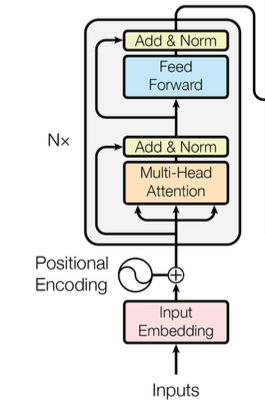

In [ ]:
class Encoder(nn.Module):
  def __init__(self, src_vocab_size, embed_size, num_layers, heads, device, max_length, dropout=0.1, forward_expansion=4):
    super(Encoder, self).__init__()

    self.embed_size = embed_size
    self.device = device
    self.word_embedding = nn.Embedding(src_vocab_size, embed_size)
    self.position_embedding = nn.Embedding(max_length, embed_size)

    self.layers = nn.ModuleList(
        [
            TransformerBlock(
                embed_size,
                heads, dropout,
                forward_expansion
              )
            for _ in range(num_layers)
        ]
    )

    self.dropout = nn.Dropout(dropout)

  def positional_encodings(self):
    pass

  def forward(self, inputs, mask):
    N, seq_length = inputs.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device) # tensor with [0,1,2,...,seq_length] to represent positions

    word_embeddings = self.word_embedding(inputs)
    position_embeddings = self.position_embedding(positions) # in the paper they use positional encodings, but using position embeddings for simplicity
    out = self.dropout(word_embeddings + position_embeddings)

    for layer in self.layers:
      out = layer(out, out, out, mask)

    return out


## Decoder

### Decoder Block

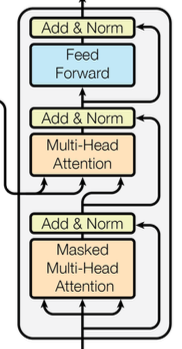

In [ ]:
class DecoderBlock(nn.Module):
  def __init__(self, embed_size, heads, dropout=0.1, forward_expansion=4):
    super(DecoderBlock, self).__init__()

    self.masked_attention = SelfAttention(embed_size=embed_size, heads=heads)
    self.norm = nn.LayerNorm(embed_size)

    self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion)

    self.dropout = nn.Dropout(dropout)

  def forward(self, values, keys, x, src_mask, trg_mask):
    '''
    values and keys: come from the encoder output
    x: the input passed in to the decoder block
    src_mask: mask applied to the transformer block
    trg_mask: mask appleid to the masked attention
    '''
    masked_attention = self.masked_attention(x, x, x, trg_mask)
    query = self.norm(masked_attention + x)
    query = self.dropout(query)

    out = self.transformer_block(values, keys, query, src_mask)

    return out

### Decoder

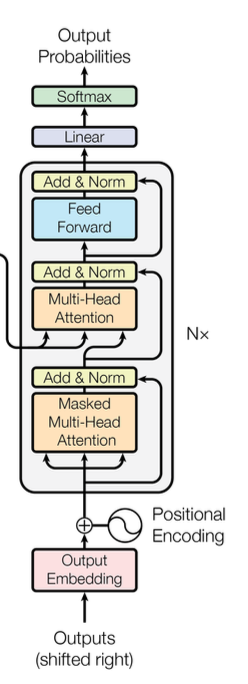

In [ ]:
class Decoder(nn.Module):

  def __init__(self, trg_vocab_size, embed_size, num_layers, heads, device, max_length, dropout=0.1, forward_expansion=4):
    super(Decoder, self).__init__()

    self.word_embedding = nn.Embedding(trg_vocab_size ,embed_size)
    self.position_embedding = nn.Embedding(max_length, embed_size)

    self.decoder_block = DecoderBlock(embed_size, heads, dropout, forward_expansion)

    self.layers = nn.ModuleList([
        DecoderBlock(
            embed_size,
            heads,
            dropout,
            forward_expansion
            )
        for _ in range(num_layers)
    ])

    self.fc_out = nn.Linear(embed_size, trg_vocab_size)
    self.dropout = nn.Dropout(dropout)
    self.device = device

  def forward(self, encoder_out, outputs, src_mask, trg_mask):
    '''
    encoder_out: comes from the output of the encoder
    outputs: what we pass into the embedding layer
    src_mask: mask applied to attention block
    trg_mask: mask applied to masked attention block
    '''
    N, seq_length = outputs.shape
    positions = torch.arange(0, seq_length).expand(N, seq_length).to(self.device) # tensor with [0,1,2,...,seq_length] to represent positions

    word_embeddings = self.word_embedding(outputs)
    position_embeddings = self.position_embedding(positions)
    x = self.dropout(word_embeddings + position_embeddings)

    for layer in self.layers:
      x = layer(encoder_out, encoder_out, x, src_mask, trg_mask)

    out = self.fc_out(x) # prediction of the next word
    out = torch.softmax(out, dim=2)

    return out

## Transformer

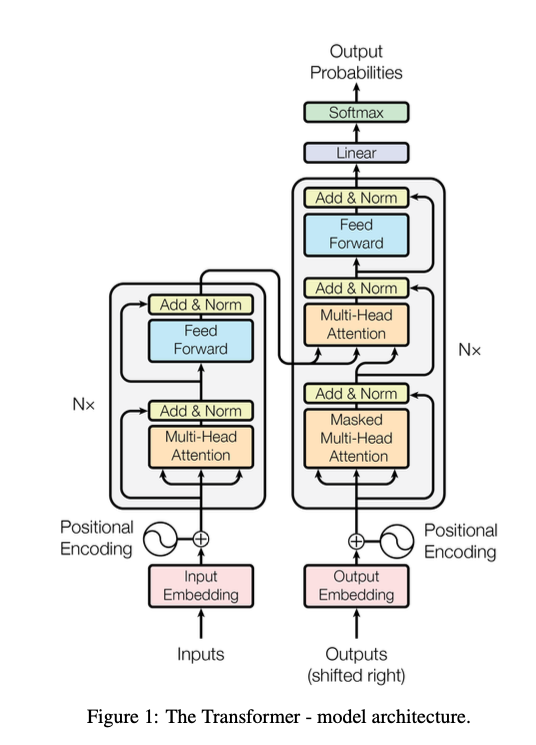

In [ ]:
class Transformer(nn.Module):
  def __init__(self,
               src_vocab_size,
               trg_vocab_size,
               src_pad_idx, # necessary to compute the mask we will use
               trg_pad_idx,
               embed_size=512,
               num_layers=6,
               heads=8,
               max_length=100,
               dropout=0.1,
               forward_expansion=4,
               device="cuda"
               ):
    super(Transformer, self).__init__()

    self.encoder = Encoder(src_vocab_size, embed_size, num_layers, heads, device, max_length, dropout, forward_expansion)
    self.decoder = Decoder(trg_vocab_size, embed_size, num_layers, heads, device, max_length, dropout, forward_expansion)

    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  def make_src_mask(self, src):
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2) # if == src_pad_idx then 0 else 1
    # (N, 1, 1, src_len)
    return src_mask.to(self.device)

  def make_trg_mask(self, trg):
    # we want to hide the future from the output i.e. prevent positions from attending to subsequent positions
    # to do this, create a lower triangle matrix with 1 in lower triangle and 0 in upper
    N, trg_len = trg.shape
    trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
        N, 1, trg_len, trg_len # expand so we have 1 for each training example
    )
    return trg_mask.to(self.device)

  def forward(self, inputs, outputs):

    src_mask = self.make_src_mask(inputs)
    trg_mask = self.make_trg_mask(outputs)

    encoder_out = self.encoder(inputs, src_mask)
    out = self.decoder(encoder_out, outputs, src_mask, trg_mask)

    return out

## Test

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x = torch.tensor([[1,5,6,4,3,9,5,2,0], [1,8,7,3,4,5,6,7,0]]).to(device) # (B, seq_len)
trg = torch.tensor([[1,7,4,3,5,9,2,1], [1,5,6,2,4,7,6,1]]).to(device) # (B, seq_len)
print(f'target shape = {trg.shape}')
print(f'device = {device}')

src_pad_idx = 0
trg_pad_idx = 0
src_vocab_size = 10
trg_vocab_size = 10
model = Transformer(src_vocab_size, trg_vocab_size, src_pad_idx, trg_pad_idx, device=device, dropout=0.0001).to(device) # returns the probabilities for each word in the sentence
out = model(x, trg[:, :-1])
print(f'output shape = {out.shape}')
print(out)

target shape = torch.Size([2, 8])
device = cpu
output shape = torch.Size([2, 7, 10])
tensor([[[0.0862, 0.1170, 0.0705, 0.0601, 0.1586, 0.1544, 0.0462, 0.0763,
          0.0886, 0.1422],
         [0.0445, 0.1383, 0.0877, 0.1486, 0.1475, 0.0357, 0.0615, 0.1615,
          0.0802, 0.0945],
         [0.0632, 0.1121, 0.1799, 0.1033, 0.0791, 0.0748, 0.0497, 0.0975,
          0.0600, 0.1804],
         [0.0556, 0.0844, 0.2276, 0.1225, 0.1121, 0.1240, 0.0333, 0.1184,
          0.0648, 0.0573],
         [0.0584, 0.1138, 0.0731, 0.0734, 0.0405, 0.0599, 0.0255, 0.1378,
          0.1076, 0.3099],
         [0.0441, 0.0867, 0.1028, 0.1514, 0.0868, 0.1530, 0.0466, 0.1877,
          0.0420, 0.0990],
         [0.0301, 0.0550, 0.2425, 0.1424, 0.1824, 0.1033, 0.0169, 0.1200,
          0.0564, 0.0510]],

        [[0.0893, 0.1523, 0.0600, 0.0477, 0.1581, 0.1786, 0.0479, 0.0628,
          0.0756, 0.1277],
         [0.0571, 0.2449, 0.0838, 0.1744, 0.0804, 0.0754, 0.0573, 0.0666,
          0.0362, 0.1239],
    

## Imports

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
from torch.utils.data import Dataset, DataLoader, random_split

from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel, WordPiece
from tokenizers.trainers import WordLevelTrainer, WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace

from pathlib import Path

from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

## Config

In [ ]:
def get_config():
  return {
      "batch_size": 8,
      "num_epochs": 20,
      "lr": 10**-4,
      "seq_len": 350,
      "d_model": 512,
      "lang_src": "en",
      "lang_tgt": "de",
      "model_folder": "drive/MyDrive/Colab Notebooks/weights",
      "model_basename": "tmodel_",
      "preload": None,
      "tokenizer_file": "drive/MyDrive/Colab Notebooks/tokenizer_{0}.json",
      "experiment_name": "runs/tmodel"
  }

In [ ]:
def get_weights_file_path(config, epoch:str):
  model_folder = config["model_folder"]
  model_basename = config["model_basename"]
  model_filename = f"{model_basename}{epoch}.pt"
  return str(Path(".") / model_folder / model_filename)


## Dataset

In [ ]:
def causal_mask(size):
  # mask previous words from the sentence for each word
  mask = torch.triu(torch.ones(1, size, size), diagonal=1).type(torch.int)
  return mask == 0 # lower triangle all True and upper all False

In [ ]:
class BilingualDataset(Dataset):
  def __init__(self, ds, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, seq_length) -> None:
    super().__init__()

    self.ds = ds
    self.tokenizer_src = tokenizer_src
    self.tokenizer_tgt = tokenizer_tgt
    self.src_lang = src_lang
    self.tgt_lang = tgt_lang

    self.seq_length = seq_length

    self.sos_token = torch.tensor([tokenizer_src.token_to_id('[SOS]')]) # we want to build the sos token into a tensor
    self.eos_token = torch.tensor([tokenizer_src.token_to_id('[EOS]')])
    self.pad_token = torch.tensor([tokenizer_src.token_to_id('[PAD]')])

  def __len__(self):
    return len(self.ds)

  def __getitem__(self, index):
    src_target_pair = self.ds[index]
    src_text = src_target_pair["translation"][self.src_lang]
    tgt_text = src_target_pair["translation"][self.tgt_lang]

    enc_input_tokens = self.tokenizer_src.encode(src_text).ids # array of the ids of the text in the vocab
    dec_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids

    # we need to pad our sentences to seq_length
    enc_num_padding_tokens = self.seq_length - len(enc_input_tokens) - 2 # leave space for SOS and EOS tokens
    dec_num_padding_tokens = self.seq_length - len(dec_input_tokens) - 1 # only keep 1 for SOS token as EOS token will be generated from transformer output

    if enc_num_padding_tokens < 0 or dec_num_padding_tokens < 0:
      raise ValueError("Sentence is too long")

    # concat SOS and EOS to the source text + pad extra length
    encoder_input = torch.cat(
        [
            self.sos_token,
            torch.tensor(enc_input_tokens, dtype=torch.int64),
            self.eos_token,
            torch.tensor([self.pad_token] * enc_num_padding_tokens, dtype=torch.int64)
        ]
    )

    decoder_input = torch.cat(
        [
            self.sos_token,
            torch.tensor(dec_input_tokens, dtype=torch.int64),
            torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64)
        ]
    )

    # output of the decoder - target (what we expect as output from the decoder)
    label = torch.cat(
        [
            torch.tensor(dec_input_tokens, dtype=torch.int64),
            self.eos_token,
            torch.tensor([self.pad_token] * dec_num_padding_tokens, dtype=torch.int64)
        ]
    )

    assert encoder_input.size(0) == self.seq_length
    assert decoder_input.size(0) == self.seq_length
    assert label.size(0) == self.seq_length

    return {
        "encoder_input": encoder_input, #(seq_length)
        "decoder_input": decoder_input, # (seq_length)
        "encoder_mask": (encoder_input != self.pad_token).unsqueeze(0).unsqueeze(0), # (1,1,seq_length) we dont want the padded elements to participate in the self attention, so we want to build a mask
        "decoder_mask": (decoder_input != self.pad_token).unsqueeze(0).unsqueeze(0) & causal_mask(decoder_input.size(0)), # (1, seq_length) & (1, seq_length, seq_length) each word can only look at the previous words, and those can only participate in the self attention
        "label": label,
        "src_text": src_text,
        "tgt_text": tgt_text
    }


## Tokenizer

We need to tokenize our raw data to send it as input to our model

In [ ]:
def get_all_sentences(ds, lang):
  for item in ds:
    yield item["translation"][lang]

In [ ]:
def get_or_build_tokenizer(config, ds, lang):
  '''
  get the tokenizer if the path exist, else builds it
  returns tokenizer
  '''
  tokenizer_path = Path(config["tokenizer_file"].format(lang))
  if not Path.exists(tokenizer_path):
    tokenizer = Tokenizer(WordPiece(unk_token='[UNK]'))
    tokenizer.pre_tokenizer = Whitespace() # splits the data based on whitespace

    trainer =  WordPieceTrainer(special_tokens=['[UNK]', '[PAD]', '[SOS]', '[EOS]'], min_frequency=2)
    tokenizer.train_from_iterator(get_all_sentences(ds, lang), trainer=trainer)
    tokenizer.save(str(tokenizer_path))
  else:
    tokenizer = Tokenizer.from_file(str(tokenizer_path))

  return tokenizer

In [ ]:
def get_ds(config):
  ds_raw = load_dataset("wmt14", "de-en", split="train")

  # Build tokenizers
  tokenizer_src = get_or_build_tokenizer(config, ds_raw, config["lang_src"])
  tokenizer_tgt = get_or_build_tokenizer(config, ds_raw, config["lang_tgt"])

  # Keep 90% for training and 10% for validation
  train_ds_size = int(0.9 * len(ds_raw))
  val_ds_size = len(ds_raw) - train_ds_size
  train_ds_raw, val_ds_raw = random_split(ds_raw, [train_ds_size, val_ds_size])

  # We need to send tensors into our model, so we will need to create a dataset
  train_ds = BilingualDataset(train_ds_raw, tokenizer_src, tokenizer_tgt, config["lang_src"], config["lang_tgt"], config["seq_len"])
  val_ds = BilingualDataset(val_ds_raw, tokenizer_src, tokenizer_tgt, config["lang_src"], config["lang_tgt"], config["seq_len"])

  max_length_src = 0
  max_length_tgt = 0
  for item in ds_raw:
    src_ids = tokenizer_src.encode(item["translation"][config["lang_src"]]).ids
    tgt_ids = tokenizer_tgt.encode(item["translation"][config["lang_tgt"]]).ids
    max_length_src = max(max_length_src, len(src_ids))
    max_length_tgt = max(max_length_tgt, len(tgt_ids))

  print(f"Max length of source sentence: {max_length_src}")
  print(f"Max length of target sentence: {max_length_tgt}")

  train_dataloader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)
  val_dataloader = DataLoader(val_ds, batch_size=1, shuffle=True)

  return train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt


## Training

In [ ]:
def train_model(config):
  # Define the device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using device {device}")

  Path(config['model_folder']).mkdir(parents=True, exist_ok=True)
  train_dataloader, val_dataloader, tokenizer_src, tokenizer_tgt = get_ds(config)
  model = Transformer(tokenizer_src.get_vocab_size(),
                      tokenizer_tgt.get_vocab_size(),
                      tokenizer_src.token_to_id('[PAD]'),
                      tokenizer_tgt.token_to_id('[PAD]'),
                      max_length=500,
                      device=device)

  # Tensorboard
  writer = SummaryWriter(config['experiment_name'])

  optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'], eps=1e-9)

  initial_epoch = 0
  global_step = 0
  if config['preload']:
    model_filename = get_weights_file_path(config, config['preload'])
    print(f"Preloading model {model_filename}")

    state = torch.load(model_filename)
    initial_epoch = state['epoch'] + 1
    optimizer.load_state_dict(state['optimizer_state_dict'])
    global_step = state['global_step']

  loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer_src.token_to_id('[PAD]'), label_smoothing=0.1).to(device)


  for epoch in range(initial_epoch, config['num_epochs']):
    model.train()
    batch_iterator = tqdm(train_dataloader, desc=f"Processing epoch {epoch:02d}")
    for batch in batch_iterator:

      encoder_input = batch['encoder_input'].to(device) # (B, seq_len)
      decoder_input = batch['decoder_input'].to(device) # (B, seq_len)
      # encoder mask = batch['encoder_mask'].to(device) # (B, 1, 1, seq_len)
      # decoder_mask = batch['decoder_mask'].to(device) # (B, 1, seq_len, seq_len)

      # Run the tensors through the transformer
      output = model(encoder_input, decoder_input) # (B, seq_len, tgt_vocab_size)

      label = batch['label'].to(device) # (B, seq_len)

      # (B, seq_len, tgt_vocab_size) -> (B*seq_len, tgt_vocab_size) --- view function returns the same tensor with the defined shape (the size -1 is inferred from other dimensions)
      loss = loss_fn(output.view(-1, tokenizer_tgt.get_vocab_size()), label.view(-1)) # loss_fn(input, target) where source is the prediction from our model and target is the expected result
      batch_iterator.set_postfix({f"loss": f"{loss.item():6.3f}"}) # update progress bar

      # Log the loss
      writer.add_scalar('train_loss', loss.item(), global_step)
      writer.flush()

      # Backpropagate the loss
      loss.backward() # updates the tensor.grad of all the previous tensors in the tree

      # Update the weights
      optimizer.step() # update weights of the model (we passed in model.parameters() at optimizer creation)
      optimizer.zero_grad() # Resets the gradients of all optimized torch.Tensor s. We don't want to keep the gradients from the previous batch run

      global_step += 1

    # Save the model at the end of every epoch
    model_filename = get_weights_file_path(config, f"{epoch:02d}")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'global_step': global_step
    }, model_filename)


In [ ]:
config = get_config()
train_model(config)

### Inference

In [ ]:
# load the tokenizers
src_lang = 'en'
tgt_lang = 'de'
tokenizer_src = Tokenizer.from_file(str(Path(config["tokenizer_file"].format(src_lang))))
tokenizer_tgt = Tokenizer.from_file(str(Path(config["tokenizer_file"].format(tgt_lang))))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = Transformer(tokenizer_src.get_vocab_size(),
                      tokenizer_tgt.get_vocab_size(),
                      tokenizer_src.token_to_id('[PAD]'),
                      tokenizer_tgt.token_to_id('[PAD]'),
                      max_length=500,
                      device=device)

In [ ]:
# load the model state dict
model.load_state_dict(torch.load('model_name.pt'))
model.eval() # set the model to evaluation mode for inference

In [ ]:
model.eval()

Transformer(
  (encoder): Encoder(
    (word_embedding): Embedding(30000, 512)
    (position_embedding): Embedding(500, 512)
    (layers): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): SelfAttention(
          (values): Linear(in_features=64, out_features=64, bias=False)
          (keys): Linear(in_features=64, out_features=64, bias=False)
          (queries): Linear(in_features=64, out_features=64, bias=False)
          (fc_out): Linear(in_features=512, out_features=512, bias=True)
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward): Sequential(
          (0): Linear(in_features=512, out_features=2048, bias=True)
          (1): ReLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder

In [ ]:
# setup input data for inference
sentence = "Hello, how are you doing?"
sos_token = torch.tensor(tokenizer_src.encode('[SOS]').ids)
eos_token = torch.tensor(tokenizer_src.encode('[EOS]').ids)
pad_token = torch.tensor(tokenizer_src.encode('[PAD]').ids)
max_length = 100
src_tokens = torch.tensor(tokenizer_src.encode(sentence).ids)
tgt_tokens = torch.tensor(tokenizer_src.encode('[SOS]').ids)

enc_num_padding_tokens = max_length - len(src_tokens) - 2
dec_num_padding_tokens = max_length - 1
print(src_tokens)
print(tgt_tokens)
print(pad_token)

tensor([26870,    15,  6534,  6100,  6108,  8369,    34])
tensor([2])
tensor([1])


In [ ]:
src_input = torch.cat(
    [
        sos_token,
        torch.tensor(src_tokens, dtype=torch.int64),
        eos_token,
        torch.tensor([pad_token] * enc_num_padding_tokens, dtype=torch.int64)
    ]
)

tgt_input = torch.cat(
    [
        torch.tensor(tgt_tokens, dtype=torch.int64), # we dont need to add the padding for inference
    ]
)

<ipython-input-213-e8ebeed8a514>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(src_tokens, dtype=torch.int64),
<ipython-input-213-e8ebeed8a514>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(tgt_tokens, dtype=torch.int64),


In [ ]:
src_input = src_input.reshape(1, max_length)
tgt_input = tgt_input.reshape(1, 1)

In [ ]:
src_input.shape

torch.Size([1, 100])

In [ ]:
tgt_input.shape

torch.Size([1, 1])

In [ ]:
with torch.no_grad():
  output = model(src_input, tgt_input)

In [ ]:
output = tgt_input # ids of the predicted translated words
for i in range(max_length):
  predictions = model(src_input, output)
  predictions = predictions[:, -1:, :] # get the last word of the predicted translated word (model is predicting next word)

  predicted_id = torch.argmax(predictions, dim=-1)
  output = torch.cat([output, predicted_id], dim=-1)

  if predicted_id == tokenizer_src.token_to_id('[EOS]'):
    break

In [ ]:
output.shape

torch.Size([1, 101])

In [ ]:
len("[SOS] masses kindergarten concept kindergarten concept bloomer wilingness sux sam kindergarten lisabeth kindergarten sawyer's sawyer's masses concept bloomer lisabeth bloomer wilingness 80000 bt hotsummer hoax hoax kieslowski wilingness 80000 dont't elis' 🐶❤️👍 cots saaaad evelynn inexperienced suji zubac forthcoming callum farmers extraordinary callum kindergarten worthy extraordinary readable 🐶❤️👍 thinkgn 🐶❤️👍 cots".split())

51

In [ ]:
output

tensor([[    2,  5520, 12659, 20385, 21038,  9147, 27035, 21461, 22471,  6065,
         10583,  2785, 14836,  4070, 24986,  2552, 10501,   812,  7572, 25205,
          3722,  4122,  3107, 24910,   349, 19767, 21258, 12764, 19547, 20385,
         19495, 18942,  8624, 26664, 10653, 12558,  8989, 10081, 15535,   576,
         24055, 22503, 24999, 25722, 29247, 28599,  4734, 13150, 18055, 27409,
         19279, 10517,  3039, 11677,  7056, 29922,  3327, 11113, 25911, 25873,
         14187, 25864, 11693, 15725, 28184,  3543,  2297, 11052,  2961, 21258,
          6065, 25609,  5485, 18409,  5357, 12764, 14951, 28072,  1092,  5873,
          7219,    90, 25184, 18757, 23217,  8485, 22184,  3244, 28767, 18055,
         18379, 28040,   625,   336, 19113,  3368, 27819,  2063, 19036, 24187,
          4354]])

In [ ]:
translation = ""
for id in output[-1]:
  translation += tokenizer_tgt.id_to_token(id) + " "

In [ ]:
translation

'[SOS] ##glich ##gnor Fun attraktiven Parteien ##iegt jung Schall ##oren einsetzen 박 Wohnzimmer ##超 DSL 辑 beschä ய ##bildung entfallen ##仁 ##臧 ##ε Konzerns ǵ beliebtesten ##olen As Verknüpf Fun ##design Finanzminister Berichts legalen ##rochen Luxus ##zeiten ##ällt Gewässer ҡ Palazzo Jungen sportlichen ##wal bestmöglich Ehrgeiz ##竞 ##reift geleiste ##ometrie ##sorgt untersch ##X Drit ##iesen Spaltung ##เ Enterp She Infe standard 115 Essen ##ault abzuhalten ##Ų 筆 Kurs ##M ##olen ##oren Cond Sp ##ichtungs ##ann As verank Sportarten ‐ ##eid ##ähigkeit w Erfordernissen Legitimität folgender ##xis Bedauern ##ξ ehemals geleiste Bedingung ##mäßigung ء Ơ Ausnahmere ##指 ##bestätigung 武 familien personal ##光 '